In [337]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

In [338]:
df = pd.read_csv("Churn_Modelling.csv")
df.shape

(10000, 14)

In [339]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [340]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [341]:
df.duplicated().sum()

np.int64(0)

In [342]:
print(df['Exited'].value_counts())


Exited
0    7963
1    2037
Name: count, dtype: int64


In [343]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('Exited')

print("\n🔹 Outlier Count (Before Capping):")
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_cap = Q1 - 1.5 * IQR
    upper_cap = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_cap) | (df[col] > upper_cap)).sum()
    print(f"{col}: {outliers}")

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_cap = Q1 - 1.5 * IQR
    upper_cap = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_cap, lower_cap, df[col])
    df[col] = np.where(df[col] > upper_cap, upper_cap, df[col])

print("\nOutlier Count (After Capping):")
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_cap = Q1 - 1.5 * IQR
    upper_cap = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_cap) | (df[col] > upper_cap)).sum()
    print(f"{col}: {outliers}")


🔹 Outlier Count (Before Capping):
RowNumber: 0
CustomerId: 0
CreditScore: 15
Age: 359
Tenure: 0
Balance: 0
NumOfProducts: 60
HasCrCard: 0
IsActiveMember: 0
EstimatedSalary: 0

Outlier Count (After Capping):
RowNumber: 0
CustomerId: 0
CreditScore: 0
Age: 0
Tenure: 0
Balance: 0
NumOfProducts: 0
HasCrCard: 0
IsActiveMember: 0
EstimatedSalary: 0


In [344]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
skew_values = df[num_cols].skew()

print("Skewness of numeric columns:\n")
print(skew_values)

Skewness of numeric columns:

RowNumber          0.000000
CustomerId         0.001149
CreditScore       -0.064255
Age                0.630315
Tenure             0.010991
Balance           -0.141109
NumOfProducts      0.567245
HasCrCard         -0.901812
IsActiveMember    -0.060437
EstimatedSalary    0.002085
Exited             1.471611
dtype: float64


In [345]:
cols_to_transform = ['Age', 'NumOfProducts']

for col in cols_to_transform:
    df[col] = np.log1p(df[col])

print("\n Skewness After Transformation:\n", df[num_cols].skew())


 Skewness After Transformation:
 RowNumber          0.000000
CustomerId         0.001149
CreditScore       -0.064255
Age                0.013543
Tenure             0.010991
Balance           -0.141109
NumOfProducts      0.292431
HasCrCard         -0.901812
IsActiveMember    -0.060437
EstimatedSalary    0.002085
Exited             1.471611
dtype: float64


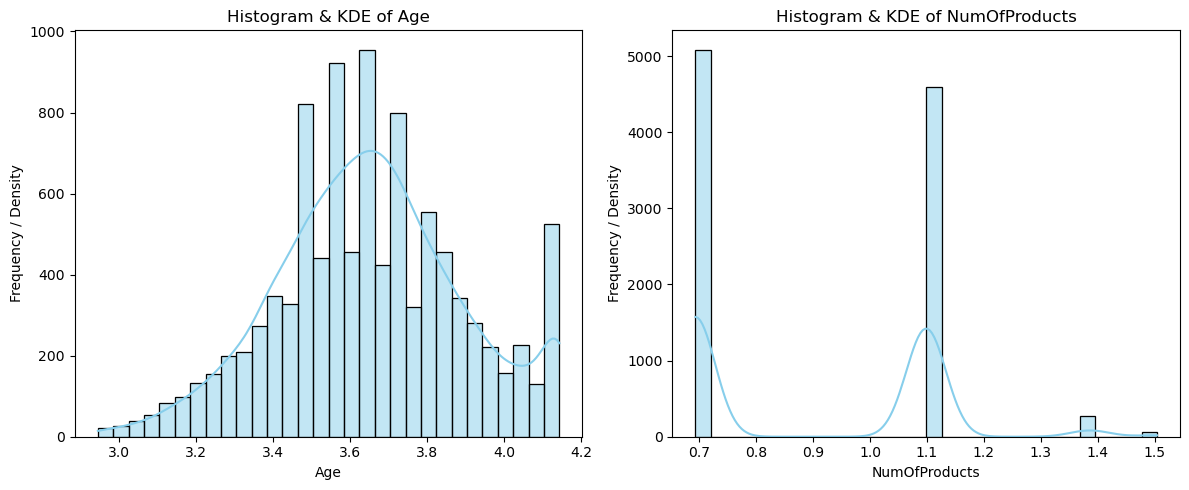

In [346]:
cols_to_plot = ['Age', 'NumOfProducts']

plt.figure(figsize=(12,5))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Histogram & KDE of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency / Density')

plt.tight_layout()
plt.show()

In [347]:
le_geo = LabelEncoder()
le_gender = LabelEncoder()
df['Geography'] = le_geo.fit_transform(df['Geography'])
df['Gender'] = le_gender.fit_transform(df['Gender'])

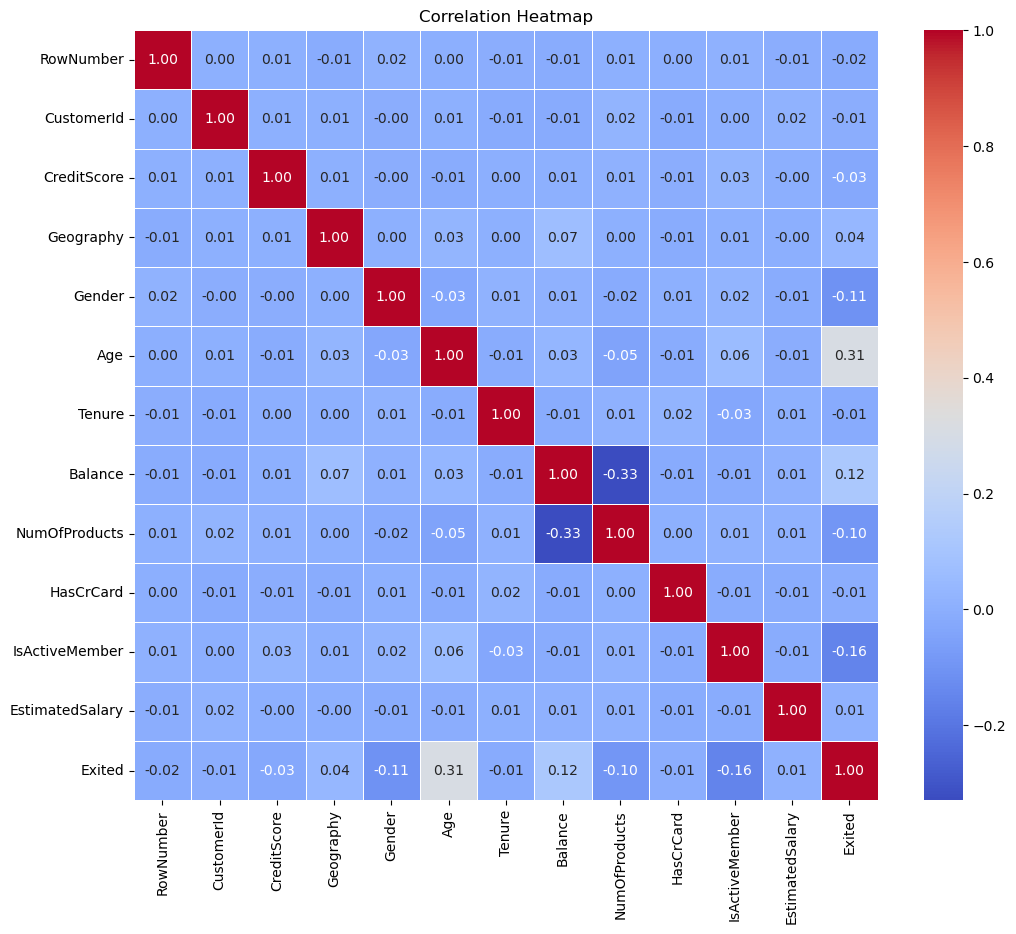

In [348]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [349]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd

X = df[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']].copy()
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Best Parameters:", grid.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
Accuracy: 0.8305
Precision: 0.5742
Recall: 0.6462
F1 Score: 0.6081
ROC-AUC: 0.8307


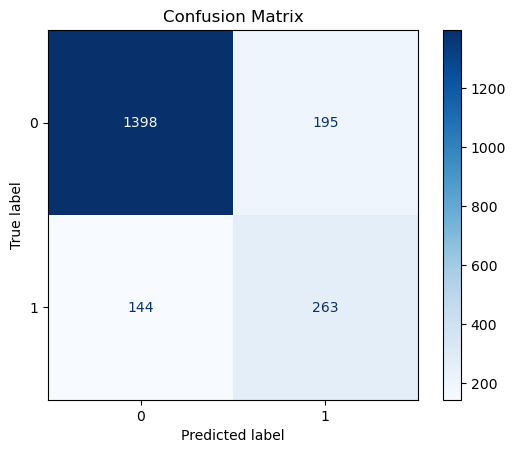

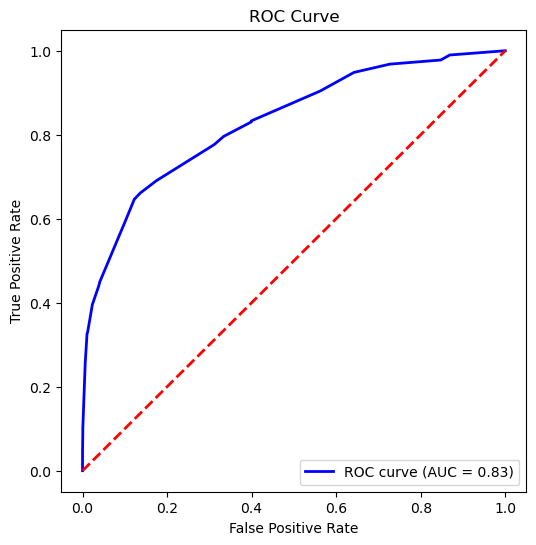

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


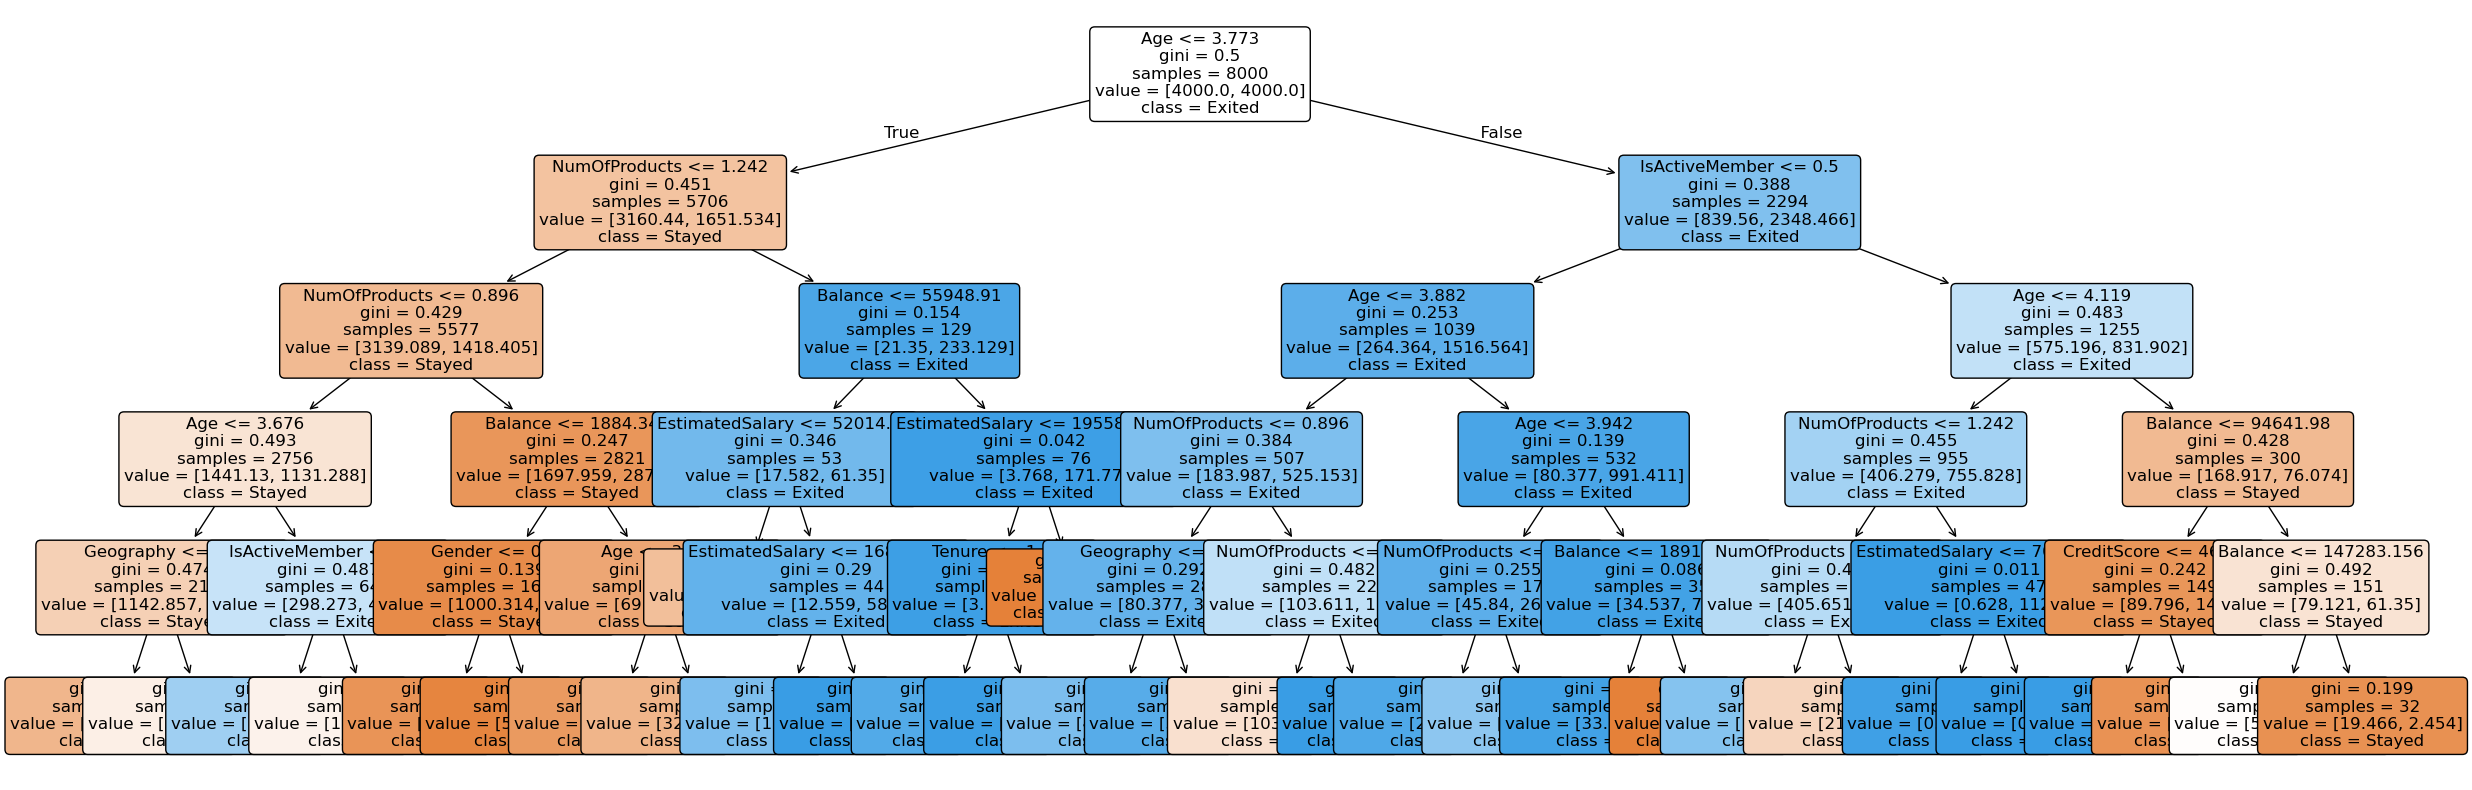

In [351]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10))
plot_tree(best_model,feature_names=X.columns,class_names=['Stayed', 'Exited'],filled=True,rounded=True, fontsize=12)
plt.show()


In [352]:
import pickle

with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)